# Noise-tolerant classification

In [1]:
# import libraries
import os
import csv
import time
import json

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics

from noisecut.model.noisecut_coder import Metric
from noisecut.model.noisecut_model import NoiseCut
from noisecut.tree_structured.data_manipulator import DataManipulator
from noisecut.tree_structured.sample_generator import SampleGenerator

# File path initialization
input_file_path = "../data/"  # Update this to your actual path
# List of dataset names
dataset_names = ["8D_E1" , "8D_E2" , "8D_E3" , "8D_E4" , "8D_E5" , "8D_E6"  ,
                 "9D_E1" , "9D_E2" , "9D_E3" , "9D_E4" , "9D_E5" , "9D_E6"  ,
                 "10D_E1", "10D_E2", "10D_E3", "10D_E4", "10D_E5", "10D_E6" ,
                 "11D_E1", "11D_E2", "11D_E3", "11D_E4", "11D_E5", "11D_E6" ,
                 "12D_E1", "12D_E2", "12D_E3", "12D_E4", "12D_E5", "12D_E6"]

## NoiseCut implementation

In [2]:
# a dictionary for storing the results
results_NC = {}

# Loop through each file
noise = [0, 2.5, 5, 7.5, 10]
Training_set_size = 70

st = time.time() #start timer

# Foor loop on noise intensity
for i in noise:
    print()
    print(f"Noise_intensity= {i}%")
    Noise_intencity = i
    
    # lists to store the results 
    accuracy_all, recall_all, precision_all, F1_all, auc_all = [], [], [], [], []
    
    #
    # For loop on sysnthetic datasets
    for dataset_name in dataset_names:
        print(f"Dataset: {dataset_name}")
        file_path = os.path.join(input_file_path, dataset_name)

        # Read the CSV file
        data = pd.read_csv(file_path, delimiter='    ', header=None, skiprows=1, engine='python')
        # Split the data into X and Y
        X = data.iloc[:, :-1]
        Y = data.iloc[:, -1]

        # Read the structure of the data
        with open(file_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=' ')
            first_row = next(reader)  # Read the first row
        # Convert the string values to integers and store in an array
        data_structure = [int(value) for value in first_row if value.strip() != '']
        
        # For loop for the number of repeating the experiment
        for j in range(5):
            # Add noise in data labeling. Then, train and test set split. 
            manipulator = DataManipulator()
            x_noisy, y_noisy = manipulator.get_noisy_data(X, Y, percentage_noise = Noise_intencity)
            x_train, y_train, x_test, y_test = manipulator.split_data(x_noisy, y_noisy, percentage_training_data = Training_set_size)


            # Fitting the hybrid model
            mdl = NoiseCut(n_input_each_box=data_structure) # 'n_input_each_box' should fit to the generated data
            mdl.fit(x_train, y_train)

            # Predictions
            y_pred_proba = mdl.predict_probability_of_being_1(x_test)
            y_pred = mdl.predict(x_test)

            # Evaluation metrics
            accuracy, recall, precision, F1 = Metric.set_confusion_matrix(y_test, y_pred)
            fpr, tpr, thresholds = metrics.roc_curve(y_test.astype(int),  y_pred_proba)
            auc = metrics.auc(fpr, tpr)

            # append to the lists
            accuracy_all.append(accuracy)
            recall_all.append(recall)
            precision_all.append(precision)
            F1_all.append(F1)
            auc_all.append(auc)

            # Store the values in the dictionary
            results_NC[f"Noise_intensity_{i}%"] = {'accuracy': accuracy_all, 
                                                   'recall': recall_all, 
                                                   'precision': precision_all,
                                                   'F1': F1_all,
                                                   'auc': auc_all}
            #


# Write the result dictionary
with open('./Noise-tolerant_classification_results/results_NC', 'w') as json_file:
    json.dump(results_NC, json_file)
    
run_time = time.time() - st
print("Runtime(seconds)=", run_time)


Noise_intensity= 0%
Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6

Noise_intensity= 2.5%
Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6

Noise_intensity= 5%

In [4]:
####################
# NoiseCut Results #
####################

# Define a list of metric names
metric_names = ['accuracy', 'recall', 'precision', 'F1', 'auc']

# Create a dictionary to store results
metric_dict_NC = {metric: {'medians': [], 'CIs': []} for metric in metric_names}

# Iterate through the results dictionary
for dict_intensity, dict_metrics in results_NC.items():
    for metric in metric_names:
        medians = np.median(dict_metrics[metric])
        CIs = stats.t.interval(0.95, len(dict_metrics[metric]) - 1, loc=medians, scale=stats.sem(dict_metrics[metric]))
        
        metric_dict_NC[metric]['medians'].append(medians)
        metric_dict_NC[metric]['CIs'].append(CIs)

# Write the result dictionary
with open('./Noise-tolerant_classification_results/metric_dict_NC', 'w') as json_file:
    json.dump(metric_dict_NC, json_file)

## XGBoost Model

In [5]:
# Define the XGBoost parameter tuning function and the model

def set_best_params_xgb(x_train, y_train, x_test, y_test):
    tuned_parameters = [
        {
            "learning_rate": [0.01, 0.1],
            "gamma": [0.4, 0.8],
            "max_depth": [6, 8],
            "n_estimators": [200, 400],
            "subsample": [0.8, 1.0],
            "early_stopping_rounds": [10, 20],
        }
    ]

    # Tuning hyperparametrs for the classifilcation accuracy
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid=tuned_parameters,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        verbose=0,
    )

    # Fit the grid search
    grid_search.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0)

    return grid_search.best_params_


def xgb_model(x_train, y_train, x_test, y_test, best_param):
    clf = xgb.XGBClassifier(
        objective="binary:logistic",
        learning_rate=best_param["learning_rate"],
        gamma=best_param["gamma"],
        max_depth=best_param["max_depth"],
        n_estimators=best_param["n_estimators"],
        subsample=best_param["subsample"],
        early_stopping_rounds=best_param["early_stopping_rounds"],
    )

    # Fitting the model with early stopping after 10 rpochs to avoid
    # overfitting
    clf = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0)
    # make predictions for test data

    ### The predicted labels ###
    return clf.predict_proba(x_test), clf.predict(x_test)

## XGBoost implementation

In [6]:
# XGBoost implementation with early stopping
# a dictionary for storing the results
results_XGB = {}

# Loop through each file
noise_list = [0, 2.5, 5, 7.5, 10]
Training_set_size = 70

st = time.time()  # start timer

# Foor loop on noise intensity
for noise_intensity in noise_list:
    print()
    print(f"Noise_intensity= {noise_intensity}%")

    # lists to store the results
    accuracy_all, recall_all, precision_all, F1_all, auc_all = (
        [],
        [],
        [],
        [],
        [],
    )

    # For loop on sysnthetic datasets
    for dataset_name in dataset_names:
        print(f"Dataset: {dataset_name}")
        file_path = os.path.join(input_file_path, dataset_name)

        # Read the CSV file
        data = pd.read_csv(
            file_path,
            delimiter="    ",
            header=None,
            skiprows=1,
            engine="python",
        )
        # Split the data into X and Y
        X = data.iloc[:, :-1]
        Y = data.iloc[:, -1]

        # Parameter tuning for each data set
        manipulator = DataManipulator()
        x_noisy, y_noisy = manipulator.get_noisy_data(
            X, Y, percentage_noise=noise_intensity
        )
        x_train, y_train, x_test, y_test = manipulator.split_data(
            x_noisy, y_noisy, percentage_training_data=Training_set_size
        )

        best_params_xgb = set_best_params_xgb(x_train, y_train, x_test, y_test)
        #print(best_params_xgb)

        # For loop for the number of repeating the experiment
        for j in range(5):
            # Add noise in data labeling. Then, train and test set split.
            x_noisy, y_noisy = manipulator.get_noisy_data(
                X, Y, percentage_noise=noise_intensity
            )
            x_train, y_train, x_test, y_test = manipulator.split_data(
                x_noisy, y_noisy, percentage_training_data=Training_set_size
            )

            # Fitting the XGBoost model
            y_pred_proba, y_pred = xgb_model(
                x_train, y_train, x_test, y_test, best_params_xgb
            )

            # Evaluation metrics
            accuracy, recall, precision, F1 = Metric.set_confusion_matrix(
                y_test, y_pred
            )
            fpr, tpr, thresholds = metrics.roc_curve(
                y_test.astype(int), y_pred_proba[::, 1]
            )
            auc = metrics.auc(fpr, tpr)

            # append to the lists
            accuracy_all.append(accuracy)
            recall_all.append(recall)
            precision_all.append(precision)
            F1_all.append(F1)
            auc_all.append(auc)

            # Store the values in the dictionary
            results_XGB[f"Noise_intensity_{noise_intensity}%"] = {
                "accuracy": accuracy_all,
                "recall": recall_all,
                "precision": precision_all,
                "F1": F1_all,
                "auc": auc_all,
            }

# Write the result dictionary
with open(
    "./Noise-tolerant_classification_results/results_XGB", "w"
) as json_file:
    json.dump(results_XGB, json_file)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)


Noise_intensity= 0%
Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6

Noise_intensity= 2.5%
Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6

Noise_intensity= 5%

In [7]:
###################
# XGBoost Results #
###################

# Define a list of metric names
metric_names = ['accuracy', 'recall', 'precision', 'F1', 'auc']

# Create a dictionary to store results
metric_dict_XGB = {metric: {'medians': [], 'CIs': []} for metric in metric_names}

# Iterate through the results dictionary
for dict_intensity, dict_metrics in results_XGB.items():
    for metric in metric_names:
        medians = np.median(dict_metrics[metric])
        CIs = stats.t.interval(0.95, len(dict_metrics[metric]) - 1, loc=medians, scale=stats.sem(dict_metrics[metric]))
        
        metric_dict_XGB[metric]['medians'].append(medians)
        metric_dict_XGB[metric]['CIs'].append(CIs)

# Write the result dictionary
with open('./Noise-tolerant_classification_results/metric_dict_XGB', 'w') as json_file:
    json.dump(metric_dict_XGB, json_file)

## SVM Model

In [2]:
from sklearn.svm import SVC

# Define the SVM parameter tuning function and the model
def set_best_params_svm(x_train, y_train, x_val, y_val):
    tuned_parameters = [
        {
            "C": [10, 100],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"],
        }
    ]

    # Tuning hyperparameters for classification accuracy
    grid_search = GridSearchCV(
        estimator=SVC(probability=True),
        param_grid=tuned_parameters,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        verbose=0,
    )

    # Fit the grid search
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_


def svm_model_with_early_stopping(x_train, y_train, x_val, y_val, max_no_improvement=5):
    clf = SVC(
        C=best_params_svm["C"],
        kernel=best_params_svm["kernel"],
        gamma=best_params_svm["gamma"],
        probability=True,
    )

    best_accuracy = 0
    no_improvement_count = 0

    # Fitting the model with early stopping
    for epoch in range(max_no_improvement):
        clf.fit(x_train, y_train)

        # Evaluate on the validation set
        val_pred = clf.predict(x_val)
        accuracy = metrics.accuracy_score(y_val, val_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= max_no_improvement:
            print(f"Early stopping after {epoch+1} epochs without improvement.")
            break

    # Return the trained model
    return clf

## SVM Implementation

In [3]:
# SVM implementation with early stopping
# a dictionary for storing the results
results_SVM = {}

# Loop through each file
noise_list = [0, 2.5, 5, 7.5, 10]
Training_set_size = 70

st = time.time()  # start timer

# For loop on noise intensity
for noise_intensity in noise_list:
    print()
    print(f"Noise_intensity= {noise_intensity}%")

    # lists to store the results
    accuracy_all, recall_all, precision_all, F1_all, auc_all = (
        [],
        [],
        [],
        [],
        [],
    )

    # For loop on synthetic datasets
    for dataset_name in dataset_names:
        print(f"Dataset: {dataset_name}")
        file_path = os.path.join(input_file_path, dataset_name)

        # Read the CSV file
        data = pd.read_csv(
            file_path,
            delimiter="    ",
            header=None,
            skiprows=1,
            engine="python",
        )
        # Split the data into X and Y
        X = data.iloc[:, :-1]
        Y = data.iloc[:, -1]

        # Parameter tuning for each dataset
        manipulator = DataManipulator()
        x_noisy, y_noisy = manipulator.get_noisy_data(
            X, Y, percentage_noise=noise_intensity
        )
        x_train, y_train, x_val, y_val = manipulator.split_data(
            x_noisy, y_noisy, percentage_training_data=Training_set_size
        )

        # Selecting the best hyperparameters
        best_params_svm = set_best_params_svm(x_train, y_train, x_val, y_val)
        #print(best_params_svm)
        
        # For loop for the number of repeating experiments
        for j in range(5):
            # Add noise in data labeling. Then, train and test split.
            x_noisy, y_noisy = manipulator.get_noisy_data(
                X, Y, percentage_noise=noise_intensity
            )
            x_train, y_train, x_val, y_val = manipulator.split_data(
                x_noisy, y_noisy, percentage_training_data=Training_set_size
            )
            
            # Fitting the SVM model with early stopping
            clf = svm_model_with_early_stopping(x_train, y_train, x_val, y_val)


            # make predictions for test data
            y_pred_proba = clf.predict_proba(x_val)
            y_pred = clf.predict(x_val)

            # Evaluation metrics
            accuracy, recall, precision, F1 = Metric.set_confusion_matrix(
                y_val, y_pred
            )
            fpr, tpr, thresholds = metrics.roc_curve(
                y_val.astype(int), y_pred_proba[::, 1]
            )
            auc = metrics.auc(fpr, tpr)

            # append to the lists
            accuracy_all.append(accuracy)
            recall_all.append(recall)
            precision_all.append(precision)
            F1_all.append(F1)
            auc_all.append(auc)

            # Store the values in the dictionary
            results_SVM[f"Noise_intensity_{noise_intensity}%"] = {
                "accuracy": accuracy_all,
                "recall": recall_all,
                "precision": precision_all,
                "F1": F1_all,
                "auc": auc_all,
            }

# Write the result dictionary
with open(
    "./Noise-tolerant_classification_results/results_SVM", "w"
) as json_file:
    json.dump(results_SVM, json_file)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)


Noise_intensity= 0%
Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6

Noise_intensity= 2.5%
Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6

Noise_intensity= 5%

In [4]:
###############
# SVM Results #
###############

# Define a list of metric names
metric_names = ['accuracy', 'recall', 'precision', 'F1', 'auc']

# Create a dictionary to store results
metric_dict_SVM = {metric: {'medians': [], 'CIs': []} for metric in metric_names}

# Iterate through the results dictionary
for dict_intensity, dict_metrics in results_SVM.items():
    for metric in metric_names:
        medians = np.median(dict_metrics[metric])
        CIs = stats.t.interval(0.95, len(dict_metrics[metric]) - 1, loc=medians, scale=stats.sem(dict_metrics[metric]))
        
        metric_dict_SVM[metric]['medians'].append(medians)
        metric_dict_SVM[metric]['CIs'].append(CIs)

# Write the result dictionary
with open('./Noise-tolerant_classification_results/metric_dict_SVM', 'w') as json_file:
    json.dump(metric_dict_SVM, json_file)

## Random Forest Model

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the RandomForest parameter tuning function and the model
def set_best_params_random_forest(x_train, y_train, x_val, y_val):
    tuned_parameters = [
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 10],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
        }
    ]

    # Tuning hyperparameters for classification accuracy
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(oob_score=True),
        param_grid=tuned_parameters,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        verbose=0,
    )

    # Fit the grid search
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_


def random_forest_model_with_early_stopping(x_train, y_train, x_val, y_val, max_no_improvement=5):
    clf = RandomForestClassifier(
        n_estimators=best_params_rf["n_estimators"],
        max_depth=best_params_rf["max_depth"],
        min_samples_split=best_params_rf["min_samples_split"],
        min_samples_leaf=best_params_rf["min_samples_leaf"],
        oob_score=True,
    )

    best_accuracy = 0
    no_improvement_count = 0

    # Fitting the model with early stopping
    for epoch in range(max_no_improvement):
        clf.fit(x_train, y_train)

        # Evaluate on the validation set
        val_pred = clf.predict(x_val)
        accuracy = accuracy_score(y_val, val_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= max_no_improvement:
            print(f"Early stopping after {epoch+1} epochs without improvement.")
            break

    # Return the trained model
    return clf

## Random Forest Implementation

In [6]:
# RandomForest implementation with early stopping
# a dictionary for storing the results
results_RandomForest = {}

# Loop through each file
noise_list = [0, 2.5, 5, 7.5, 10]
Training_set_size = 70

st = time.time()  # start timer

# For loop on noise intensity
for noise_intensity in noise_list:
    print()
    print(f"Noise_intensity= {noise_intensity}%")

    # lists to store the results
    accuracy_all, recall_all, precision_all, F1_all, auc_all = (
        [],
        [],
        [],
        [],
        [],
    )

    # For loop on synthetic datasets
    for dataset_name in dataset_names:
        print(f"Dataset: {dataset_name}")
        file_path = os.path.join(input_file_path, dataset_name)

        # Read the CSV file
        data = pd.read_csv(
            file_path,
            delimiter="    ",
            header=None,
            skiprows=1,
            engine="python",
        )
        # Split the data into X and Y
        X = data.iloc[:, :-1]
        Y = data.iloc[:, -1]

        # Parameter tuning for each dataset
        manipulator = DataManipulator()
        x_noisy, y_noisy = manipulator.get_noisy_data(
            X, Y, percentage_noise=noise_intensity
        )
        x_train, y_train, x_val, y_val = manipulator.split_data(
            x_noisy, y_noisy, percentage_training_data=Training_set_size
        )
        
        # Selecting the best hyperparameters
        best_params_rf = set_best_params_random_forest(x_train, y_train, x_val, y_val)
        #print(best_params_rf)
        
        # For loop for the number of repeating experiments
        for j in range(5):
            # Add noise in data labeling. Then, train and test split.
            x_noisy, y_noisy = manipulator.get_noisy_data(
                X, Y, percentage_noise=noise_intensity
            )
            x_train, y_train, x_val, y_val = manipulator.split_data(
                x_noisy, y_noisy, percentage_training_data=Training_set_size
            )

            # Fitting the RandomForest model with early stopping
            clf = random_forest_model_with_early_stopping(x_train, y_train, x_val, y_val)

            # make predictions for test data
            y_pred_proba = clf.predict_proba(x_val)
            y_pred = clf.predict(x_val)

            # Evaluation metrics
            accuracy, recall, precision, F1 = Metric.set_confusion_matrix(
                y_val, y_pred
            )
            fpr, tpr, thresholds = metrics.roc_curve(
                y_val.astype(int), y_pred_proba[::, 1]
            )
            auc = metrics.auc(fpr, tpr)

            # append to the lists
            accuracy_all.append(accuracy)
            recall_all.append(recall)
            precision_all.append(precision)
            F1_all.append(F1)
            auc_all.append(auc)

            # Store the values in the dictionary
            results_RandomForest[f"Noise_intensity_{noise_intensity}%"] = {
                "accuracy": accuracy_all,
                "recall": recall_all,
                "precision": precision_all,
                "F1": F1_all,
                "auc": auc_all,
            }

# Write the result dictionary
with open(
    "./Noise-tolerant_classification_results/results_RandomForest", "w"
) as json_file:
    json.dump(results_RandomForest, json_file)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)


Noise_intensity= 0%
Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6

Noise_intensity= 2.5%
Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6

Noise_intensity= 5%

In [7]:
#########################
# Random Forest Results #
#########################

# Define a list of metric names
metric_names = ['accuracy', 'recall', 'precision', 'F1', 'auc']

# Create a dictionary to store results
metric_dict_RandomForest = {metric: {'medians': [], 'CIs': []} for metric in metric_names}

# Iterate through the results dictionary
for dict_intensity, dict_metrics in results_RandomForest.items():
    for metric in metric_names:
        medians = np.median(dict_metrics[metric])
        CIs = stats.t.interval(0.95, len(dict_metrics[metric]) - 1, loc=medians, scale=stats.sem(dict_metrics[metric]))
        
        metric_dict_RandomForest[metric]['medians'].append(medians)
        metric_dict_RandomForest[metric]['CIs'].append(CIs)

# Write the result dictionary
with open('./Noise-tolerant_classification_results/metric_dict_RandomForest', 'w') as json_file:
    json.dump(metric_dict_RandomForest, json_file)

## Deep Neural Network Implementation

In [8]:
###############################################################################################
# Note:                                                                                       #
# The calculations of deep neural network model are not included in this notebook to avoid    #
# complications of Tensorflow and its dependencies installation.                              #
# The codes are provided below just for illustration.                                         #
###############################################################################################

# # import Tensorflow related libraries
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.callbacks import EarlyStopping

# # Define the Neural Network function with variable hidden layer sizes
# def create_neural_network(hidden_layer_sizes=[64]):
#     model = Sequential()
#     for size in hidden_layer_sizes:
#         model.add(Dense(size, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# # Neural Network implementation with hyperparameter tuning using GridSearchCV
# # a dictionary for storing the results
# results_NeuralNetwork = {}

# # Loop through each file
# noise_list = [0, 2.5, 5, 7.5, 10]
# Training_set_size = 70

# st = time.time()  # start timer

# # For loop on noise intensity
# for noise_intensity in noise_list:
#     print()
#     print(f"Noise_intensity= {noise_intensity}%")

#     # lists to store the results
#     accuracy_all, recall_all, precision_all, F1_all, auc_all = (
#         [],
#         [],
#         [],
#         [],
#         [],
#     )

#     # For loop on synthetic datasets
#     for dataset_name in dataset_names:
#         print(f"Dataset: {dataset_name}")
#         file_path = os.path.join(input_file_path, dataset_name)

#         # Read the CSV file
#         data = pd.read_csv(
#             file_path,
#             delimiter="    ",
#             header=None,
#             skiprows=1,
#             engine="python",
#         )
#         # Split the data into X and Y
#         X = data.iloc[:, :-1]
#         Y = data.iloc[:, -1]

#         # Parameter tuning for each dataset
#         manipulator = DataManipulator()
#         x_noisy, y_noisy = manipulator.get_noisy_data(
#             X, Y, percentage_noise=noise_intensity
#         )
#         x_train, x_val, y_train, y_val = train_test_split(
#             x_noisy, y_noisy, test_size=0.3, random_state=42
#         )

#         # Define the parameter grid for hyperparameter tuning
#         param_grid = {
#             'hidden_layer_sizes': [(128,), (256,), (512,), 
#                                    (256, 128), (512, 256), 
#                                    (256, 128, 64), (512, 256, 128)],
#             'epochs': [50, 100, 200],
#         }

#         # Build and train the Neural Network with hyperparameter tuning
#         model = KerasClassifier(build_fn=create_neural_network, verbose=0)
#         early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#         grid_search = GridSearchCV(
#             estimator=model,
#             param_grid=param_grid,
#             scoring='accuracy',
#             cv=StratifiedKFold(n_splits=5, shuffle=True),
#             verbose=0
#         )
#         grid_result = grid_search.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping])

#         # Get the best parameters from the grid search
#         best_params = grid_result.best_params_

#         # Build the final model with the best parameters
#         final_model = create_neural_network(hidden_layer_sizes=best_params['hidden_layer_sizes'])
#         final_model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), verbose=0, callbacks=[early_stopping])

#         # make predictions for validation data
#         y_pred_proba = final_model.predict(x_val)
#         y_pred = (y_pred_proba > 0.5).astype(int)

#         # Evaluation metrics
#         accuracy, recall, precision, F1 = Metric.set_confusion_matrix(
#             y_val, y_pred
#         )
#         fpr, tpr, thresholds = metrics.roc_curve(
#             y_val.astype(int), y_pred_proba
#         )
#         auc = metrics.auc(fpr, tpr)

#         # append to the lists
#         accuracy_all.append(accuracy)
#         recall_all.append(recall)
#         precision_all.append(precision)
#         F1_all.append(F1)
#         auc_all.append(auc)

#         # Store the values in the dictionary
#         results_NeuralNetwork[f"Noise_intensity_{noise_intensity}%"] = {
#             "accuracy": accuracy_all,
#             "recall": recall_all,
#             "precision": precision_all,
#             "F1": F1_all,
#             "auc": auc_all,
#         }

# # Write the result dictionary
# with open(
#     "./Noise-tolerant_classification_results/results_NeuralNetwork", "w"
# ) as json_file:
#     json.dump(results_NeuralNetwork, json_file)

# run_time = time.time() - st
# print("Runtime(seconds)=", run_time)

## Plots

In [9]:
# Read the saved results
with open('./Noise-tolerant_classification_results/metric_dict_NC', 'r') as json_file:
    metric_dict_NC = json.load(json_file)
    
    
with open('./Noise-tolerant_classification_results/metric_dict_XGB', 'r') as json_file:
    metric_dict_XGB = json.load(json_file)


with open('./Noise-tolerant_classification_results/metric_dict_SVM', 'r') as json_file:
    metric_dict_SVM = json.load(json_file)
    
    
with open('./Noise-tolerant_classification_results/metric_dict_RandomForest', 'r') as json_file:
    metric_dict_rf = json.load(json_file)


with open('./Noise-tolerant_classification_results/metric_dict_NeuralNetwork', 'r') as json_file:
    metric_dict_NeuralNetwork = json.load(json_file)

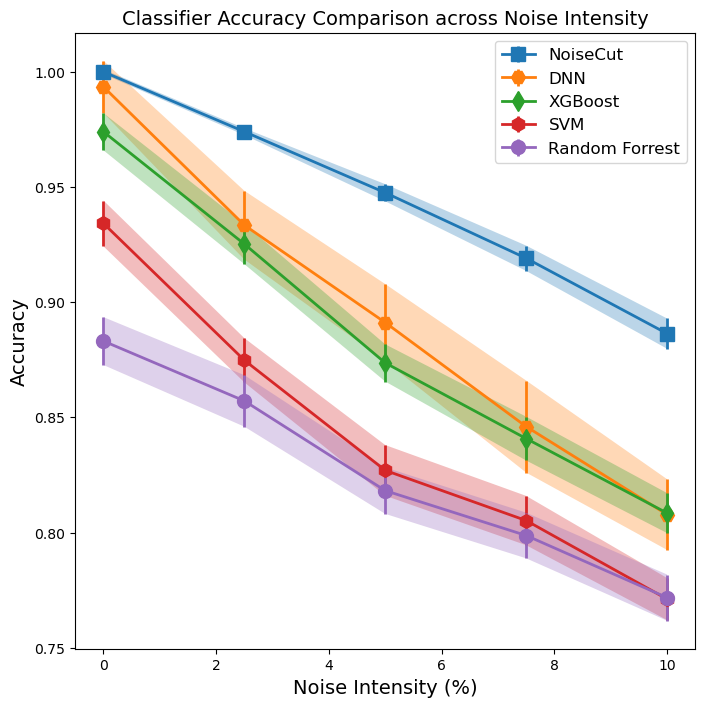

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

noise_list = [0, 2.5, 5, 7.5, 10]

##############
# error bars #
##############
error_accuracy_NC = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_NC["accuracy"]["CIs"]
]

error_accuracy_XGB = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_XGB["accuracy"]["CIs"]
]

error_accuracy_SVM = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_SVM["accuracy"]["CIs"]
]

error_accuracy_rf = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_rf["accuracy"]["CIs"]
]

error_accuracy_NeuralNetwork = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_NeuralNetwork["accuracy"]["CIs"]
]

# Plots:
#####################
# NoiseCut Accuracy #
#####################
plt.errorbar(
    noise_list,
    metric_dict_NC["accuracy"]["medians"],
    yerr=error_accuracy_NC,
    marker="s",
    label="NoiseCut",
    linewidth=2,
    markersize=10,
    #color="peru",
)
plt.fill_between(
    noise_list,
    [
        x - y
        for x, y in zip(
            metric_dict_NC["accuracy"]["medians"], error_accuracy_NC
        )
    ],
    [
        x + y
        for x, y in zip(
            metric_dict_NC["accuracy"]["medians"], error_accuracy_NC
        )
    ],
    alpha=0.3,
    #color="peru",
)

################
# DNN Accuracy #
################
plt.errorbar(
    noise_list,
    metric_dict_NeuralNetwork["accuracy"]["medians"],
    yerr=error_accuracy_NeuralNetwork,
    marker="H",
    label="DNN",
    linewidth=2,
    markersize=10,
    #color="teal",
)
plt.fill_between(
    noise_list,
    [
        x - y
        for x, y in zip(
            metric_dict_NeuralNetwork["accuracy"]["medians"], error_accuracy_NeuralNetwork
        )
    ],
    [
        x + y
        for x, y in zip(
            metric_dict_NeuralNetwork["accuracy"]["medians"], error_accuracy_NeuralNetwork
        )
    ],
    alpha=0.3,
    #color="teal",
)

####################
# XGBoost Accuracy #
####################
plt.errorbar(
    noise_list,
    metric_dict_XGB["accuracy"]["medians"],
    yerr=error_accuracy_XGB,
    marker="d",
    label="XGBoost",
    linewidth=2,
    markersize=10,
    #color="royalblue",
)
plt.fill_between(
    noise_list,
    [
        x - y
        for x, y in zip(
            metric_dict_XGB["accuracy"]["medians"], error_accuracy_XGB
        )
    ],
    [
        x + y
        for x, y in zip(
            metric_dict_XGB["accuracy"]["medians"], error_accuracy_XGB
        )
    ],
    alpha=0.3,
    #color="royalblue",
)

################
# SVM Accuracy #
################
plt.errorbar(
    noise_list,
    metric_dict_SVM["accuracy"]["medians"],
    yerr=error_accuracy_SVM,
    marker="h",
    label="SVM",
    linewidth=2,
    markersize=10,
    #color="firebrick",
)
plt.fill_between(
    noise_list,
    [
        x - y
        for x, y in zip(
            metric_dict_SVM["accuracy"]["medians"], error_accuracy_SVM
        )
    ],
    [
        x + y
        for x, y in zip(
            metric_dict_SVM["accuracy"]["medians"], error_accuracy_SVM
        )
    ],
    alpha=0.3,
    #color="firebrick",
)

##########################
# Random Forest Accuracy #
##########################
plt.errorbar(
    noise_list,
    metric_dict_rf["accuracy"]["medians"],
    yerr=error_accuracy_rf,
    marker="o",
    label="Random Forrest",
    linewidth=2,
    markersize=10,
    #color="teal",
)
plt.fill_between(
    noise_list,
    [
        x - y
        for x, y in zip(
            metric_dict_rf["accuracy"]["medians"], error_accuracy_rf
        )
    ],
    [
        x + y
        for x, y in zip(
            metric_dict_rf["accuracy"]["medians"], error_accuracy_rf
        )
    ],
    alpha=0.3,
    #color="teal",
)

##################################################
# Set common titles and labels for both subplots #
##################################################
ax.set_title("Classifier Accuracy Comparison across Noise Intensity", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xlabel("Noise Intensity (%)", fontsize=14)
ax.legend(loc="upper right", fontsize=12)

###################
# Save the figure #
###################
fig.savefig("./accuracy_comparison_noise_intensity_withDNN.png", dpi=300, bbox_inches='tight')